In [1]:
import random
import math
from dataclasses import dataclass
from typing import Dict, List, Tuple, Iterable, Optional
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt, csv, json
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')  # 또는 'retina'

In [2]:
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())

print("backend =", plt.get_backend())

torch: 2.8.0+cpu
cuda available: False
backend = inline


### A-1. 텍스트 프로토타입 개선 (프롬프트 앙상블)

의도: 카테고리 간 “결정적 차이”를 말로 강조 → 임베딩 간격 확대.

[방법]

동의어를 구조적 템플릿으로 확장:
"{color} {material} {fit} {category} with {detail}"
예) "white cotton slim-fit dress shirt with collar", "blue denim long-sleeve shirt with buttons"

속성별 가중 평균: 색/핏/소재/디테일 등 핵심 속성 문장을 더 큰 가중치로 평균(또는 max-pool).

기대 효과: 상위 카테고리 점수 ↑, 혼동 카테고리 점수 ↓ ⇒ top1–top2 마진 커짐.

# 📚 관련 논문·참고 자료

## 1. Prompt Engineering / Prompt Ensemble
- **Radford et al. (2021), *Learning Transferable Visual Models From Natural Language Supervision (CLIP)***  
  👉 CLIP 원 논문에서도 단일 텍스트 대신 여러 템플릿(예: *“a photo of a {label}”, “a picture of a {label}”*)을 평균해서 class prototype을 만듦.  
  **핵심**: 단일 표현 대신 프롬프트 앙상블이 성능을 안정화/개선.

- **Zhou et al. (2022), *Learning to Prompt for Vision-Language Models (CoOp)***  
  👉 수동 템플릿 대신 *learnable prompt*를 제안.  
  하지만 아이디어의 뿌리는 **다양한 프롬프트 조합 → 임베딩 평균**.

- **Zhou et al. (2022), *Conditional Prompt Learning for Vision-Language Models (CoCoOp)***  
  👉 카테고리마다 다르게 조정되는 프롬프트를 학습.  
  **핵심**: 다양한 텍스트 표현으로 프로토타입을 풍부하게 만드는 것이 중요.

---

## 2. Negative Prompting / Counter-Prototype
- **Shen et al. (2022), *How Much Can CLIP Benefit Vision-and-Language Tasks?***  
  👉 단순히 긍정 프롬프트만 쓰지 않고, 혼동되는 다른 class를 **음성 프로토타입**으로 추가해 차이를 강조하는 기법 소개.

- **Kim et al. (2023), *DeBiasing CLIP via Prompt Regularization***  
  👉 잘못된/헷갈리는 프롬프트를 넣어 감점하는 방식이 **bias 완화**와 **decision sharpening**에 유효함을 보임.

---

## 3. Prototype Refinement (Clustering, Whitening 등)
- **Wei et al. (2022), *ProDA: Efficient Prompt Learning for Vision-Language Models***  
  👉 프롬프트 다양화를 많이 하고, 이후 **clustering/selection**을 통해 대표 프로토타입을 생성.

- **Wang et al. (2023), *CLIP-Adapter: Better Vision-Language Models with Feature Adapters***  
  👉 학습 기반 후처리이긴 하지만, **whitening/linear transform**으로 in-domain 분포를 맞추는 것이 효과적임을 보임.


In [3]:
CATEGORIES: Dict[str, List[str]] = {
    "white_dress_shirt": [
        "a photo of a white dress shirt", "a white button-up shirt", "a white long-sleeve shirt"
    ],
    "hat": [
        "a photo of a baseball cap", "a photo of a hat", "a black cap"
    ],
    "denim_shirt": [
        "a photo of a denim shirt", "a blue denim shirt"
    ],
    "jeans": [
        "a photo of blue jeans", "a photo of denim pants"
    ],
    "white_tshirt": [
        "a photo of a white t-shirt", "a plain white tee"
    ],
    "pants" : [
        "a photo of a pants"
    ]
}

In [4]:
# -----------------------------------------
# 1) 속성 사전 (전역 기본 + 카테고리별 오버라이드 가능)
#    * 영어 위주 권장 (CLIP 영문 최적화)
# -----------------------------------------
ATTR_LEXICON_GLOBAL = {
    "color":  ["white", "blue", "black", "navy", "beige", "grey"],
    "material":["cotton", "denim", "linen", "polyester"],
    "fit":    ["slim-fit", "regular", "oversized"],
    "detail": ["with collar", "with buttons", "with chest pocket"]
}

# 카테고리별 특화 속성 (없으면 전역 사용)
ATTR_LEXICON_PER_CATEGORY = {
    "white_dress_shirt": {
        "color": ["white"],
        "material": ["cotton", "poplin"],
        "fit": ["slim-fit", "regular"],
        "detail": ["with collar", "with buttons"]
    },
    "denim_shirt": {
        "color": ["blue", "light blue", "dark blue"],
        "material": ["denim"],
        "fit": ["regular", "oversized"],
        "detail": ["with chest pocket", "with snap buttons"]
    },
    "jeans": {
        "color": ["blue", "light blue", "dark blue", "black"],
        "material": ["denim"],
        "fit": ["slim-fit", "regular", "straight"],
        "detail": ["with five pockets"]
    },
    "white_tshirt": {
        "color": ["white"],
        "material": ["cotton"],
        "fit": ["regular", "oversized"],
        "detail": ["crew neck", "round neck"]
    },
    "pants": {
        "color": ["black", "navy", "beige", "grey"],
        "material": ["cotton", "wool", "polyester"],
        "fit": ["slim-fit", "regular", "tapered"],
        "detail": ["with belt loops", "with side pockets"]
    },
    "hat": {
        "color": ["black", "navy", "white"],
        "material": ["cotton", "wool"],
        "fit": ["adjustable"],
        "detail": ["with curved brim", "with strapback"]
    }
}

# -----------------------------------------
# 2) 프롬프트 템플릿
#    * 간단·중간·풍부형 혼합
# -----------------------------------------
TEMPLATES = [
    "{color} {material} {fit} {category} {detail}",
    "{fit} {color} {category}",
    "{color} {category}",
    "a {color} {category} {detail}",
    "a photo of a {color} {category}",
]

# -----------------------------------------
# 3) 음성(negative) 카테고리 매핑 (헷갈리는 이웃)
#    * 필요 시 자유롭게 수정
# -----------------------------------------
NEG_NEIGHBORS = {
    "white_dress_shirt": ["white_tshirt", "denim_shirt", "hat"],
    "denim_shirt": ["white_dress_shirt", "white_tshirt"],
    "jeans": ["pants"],
    "pants": ["jeans"],
    "white_tshirt": ["white_dress_shirt"],
    "hat": ["white_tshirt", "denim_shirt"]
}


In [5]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "openai/clip-vit-base-patch32"

In [7]:
@dataclass
class Weights:
    cat: float = 0.5
    color: float = 0.2
    fit: float = 0.15
    detail: float = 0.15
    material: float = 0.0  # 필요 시 활성화

WEIGHTS = Weights()

In [8]:
# -----------------------------------------
# 5) 유틸: 속성 사전 가져오기 (카테고리별 오버라이드)
# -----------------------------------------
def get_attr_lexicon(category: str):
    base = ATTR_LEXICON_GLOBAL
    over = ATTR_LEXICON_PER_CATEGORY.get(category, {})
    merged = {k: over.get(k, base.get(k, [])) for k in ["color", "material", "fit", "detail"]}
    return merged

In [9]:
# -----------------------------------------
# 6) 프롬프트 자동 생성 (무작위 샘플링, 중복 제거)
# -----------------------------------------
def sample_prompts_for_category(category: str, n: int = 30) -> List[str]:
    attrs = get_attr_lexicon(category)
    bag = set()
    for _ in range(n * 2):  # 여유롭게 뽑고 중복 제거
        t = random.choice(TEMPLATES)
        s = t.format(
            color=random.choice(attrs["color"]) if attrs["color"] else "",
            material=random.choice(attrs["material"]) if attrs["material"] else "",
            fit=random.choice(attrs["fit"]) if attrs["fit"] else "",
            detail=random.choice(attrs["detail"]) if attrs["detail"] else "",
            category=category.replace("_", " ")
        ).replace("  ", " ").strip()
        bag.add(s)
        if len(bag) >= n:
            break
    return list(bag)

In [10]:
# -----------------------------------------
# 7) 짧은 속성 강조 문장군 생성 (가중 평균용)
# -----------------------------------------
def make_attribute_phrases(category: str) -> Dict[str, List[str]]:
    attrs = get_attr_lexicon(category)
    phrases = {
        "color":  [f"{c} {category.replace('_',' ')}" for c in attrs["color"]],
        "fit":    [f"{f} {category.replace('_',' ')}" for f in attrs["fit"]],
        "detail": [f"{category.replace('_',' ')} {d}" for d in attrs["detail"]],
        "material":[f"{m} {category.replace('_',' ')}" for m in attrs["material"]],
    }
    # 간단한 기본 카테고리 문장
    phrases["category"] = [f"a photo of a {category.replace('_',' ')}", f"a {category.replace('_',' ')}"]
    return phrases

In [11]:
# -----------------------------------------
# 8) 텍스트 임베딩 추출
# -----------------------------------------
class TextEmbedder:
    def __init__(self, model_name=MODEL_NAME, device=DEVICE):
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.proc = CLIPProcessor.from_pretrained(model_name)
        self.device = device

    @torch.no_grad()
    def embed_texts(self, texts: List[str], batch_size: int = 32) -> torch.Tensor:
        out = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = self.proc(text=batch, return_tensors="pt", padding=True, truncation=True).to(self.device)
            feats = self.model.get_text_features(**inputs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            out.append(feats)
        return torch.cat(out, dim=0)

In [12]:
# -----------------------------------------
# 9) 프로토타입 생성: (a) 앙상블 평균, (b) 속성 가중 평균
# -----------------------------------------
def build_prototype_for_category(category: str, embedder: TextEmbedder, n_samples:int=30) -> torch.Tensor:
    # (a) 템플릿×속성 자동 확장
    prompts = sample_prompts_for_category(category, n=n_samples)
    emb_a = embedder.embed_texts(prompts).mean(dim=0, keepdim=True)
    # (b) 속성 가중 평균
    phrases = make_attribute_phrases(category)
    cat_e = embedder.embed_texts(phrases["category"]).mean(0, keepdim=True)
    color_e = embedder.embed_texts(phrases["color"]).mean(0, keepdim=True) if phrases["color"] else 0
    fit_e = embedder.embed_texts(phrases["fit"]).mean(0, keepdim=True) if phrases["fit"] else 0
    detail_e = embedder.embed_texts(phrases["detail"]).mean(0, keepdim=True) if phrases["detail"] else 0
    material_e = embedder.embed_texts(phrases["material"]).mean(0, keepdim=True) if phrases["material"] else 0

    weighted = (
        WEIGHTS.cat * cat_e +
        (WEIGHTS.color * color_e if isinstance(color_e, torch.Tensor) else 0) +
        (WEIGHTS.fit * fit_e if isinstance(fit_e, torch.Tensor) else 0) +
        (WEIGHTS.detail * detail_e if isinstance(detail_e, torch.Tensor) else 0) +
        (WEIGHTS.material * material_e if isinstance(material_e, torch.Tensor) else 0)
    )

    proto = (emb_a + weighted) / 2.0
    proto = proto / proto.norm(dim=-1, keepdim=True)
    return proto  # shape: (1, d)

# -----------------------------------------
# 10) 전체 카테고리 프로토타입 사전
# -----------------------------------------
def build_all_prototypes(categories: Dict[str, List[str]], n_samples:int=30) -> Tuple[Dict[str, torch.Tensor], TextEmbedder]:
    embedder = TextEmbedder()
    prototypes = {}
    for cat in categories.keys():
        prototypes[cat] = build_prototype_for_category(cat, embedder, n_samples=n_samples)
    return prototypes, embedder

# -----------------------------------------
# 11) 음성(negative) 프로토타입 (양성처럼 동일 방식으로 생성)
# -----------------------------------------
def build_negative_prototype(category: str, prototypes: Dict[str, torch.Tensor]) -> Optional[torch.Tensor]:
    neg_cands = NEG_NEIGHBORS.get(category, [])
    if not neg_cands:
        return None
    negs = [prototypes[c] for c in neg_cands if c in prototypes]
    if not negs:
        return None
    neg = torch.stack([t.squeeze(0) for t in negs], dim=0).mean(dim=0, keepdim=True)
    neg = neg / neg.norm(dim=-1, keepdim=True)
    return neg

In [22]:
@torch.no_grad()
def score_images(
    image_paths: List[str],
    prototypes: Dict[str, torch.Tensor],
    embedder: TextEmbedder,
    beta: float = 0.2,
    temperature: float = 0.7,
    zscore_per_image: bool = True
):
    imgs = [Image.open(p).convert("RGB") for p in image_paths]
    inputs = embedder.proc(images=imgs, return_tensors="pt").to(embedder.device)
    img_feats = embedder.model.get_image_features(**inputs)
    img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)  # (B, d)

    cat_names = list(prototypes.keys())
    P = torch.cat([prototypes[c] for c in cat_names], dim=0)  # (K, d)

    neg_map = {c: build_negative_prototype(c, prototypes) for c in cat_names}

    pos_scores = img_feats @ P.T
    neg_scores = torch.zeros_like(pos_scores)
    for j, c in enumerate(cat_names):
        nproto = neg_map[c]
        if nproto is not None:
            neg_scores[:, j] = (img_feats @ nproto.T).squeeze(-1)

    scores = pos_scores - beta * neg_scores

    if zscore_per_image:
        mu = scores.mean(dim=1, keepdim=True)
        std = scores.std(dim=1, keepdim=True).clamp_min(1e-6)
        scores = (scores - mu) / std

    logits = scores / max(1e-6, temperature)
    probs = torch.softmax(logits, dim=-1)  # (B, K)
    return probs, cat_names

In [16]:
DATA = Path("/workspace/data/images")
OUT  = Path("/workspace/out"); OUT.mkdir(parents=True, exist_ok=True)
imgs = sorted([p for p in DATA.glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}])[:10]
assert imgs, "Put ~10 images into /workspace/data/images first."

In [ ]:
print(f"Building prototypes on {DEVICE} ...")
prototypes, embedder = build_all_prototypes(CATEGORIES, n_samples=30)
print(f"Built {len(prototypes)} prototypes.")

# 2) 이미지 점수 계산 (이미지 경로 예시 수정)
demo_images = [
    # 예: "./samples/white_dress_shirt_01.jpg",
    #     "./samples/jeans_02.jpg",
]
if len(imgs) == 0:
    print("※ demo_images 리스트에 테스트할 이미지 경로를 넣으세요.")
else:
    results, summary = score_images(
        image_paths=imgs,
        prototypes=prototypes,
        embedder=embedder,
        beta=0.2,          
        temperature=0.7,    
        zscore_per_image=True
    )
    print("Summary:", summary)

Building prototypes on cpu ...
Built 6 prototypes.
Summary: {'avg_margin': 0.6348109245300293, 'avg_entropy': 0.892803966999054, 'temperature': 0.7, 'beta': 0.2, 'zscore': True}


In [33]:
def plot_top1_grid(image_paths, probs_torch, cat_names, out_dir="out", cols=5, thumb_size=192):
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)

    probs = probs_torch.detach().cpu().numpy()   # (N, K)
    pred_top1 = probs.argmax(axis=1)             # (N,)
    score_top1 = probs.max(axis=1)               # (N,)

    thumbs = []
    for p in image_paths:
        im = Image.open(p).convert("RGB").resize((thumb_size, thumb_size))
        thumbs.append(np.asarray(im))

    N = len(thumbs)
    rows = (N + cols - 1) // cols
    plt.figure(figsize=(cols * 2.2, rows * 2.2))

    for i, (im, pred, sc) in enumerate(zip(thumbs, pred_top1, score_top1), start=1):
        ax = plt.subplot(rows, cols, i)
        ax.imshow(im); ax.axis("off")
        ax.set_title(f"img{i}: {cat_names[int(pred)]}\nscore={float(sc):.3f}", fontsize=9)

    plt.tight_layout()
    out_path  = Path("/workspace/out/thumbs_pred_top1_prompt_ensemble.png")

    plt.savefig(out_path, dpi=160)
    plt.show()
    print(f"[saved] {out_path.resolve()}")

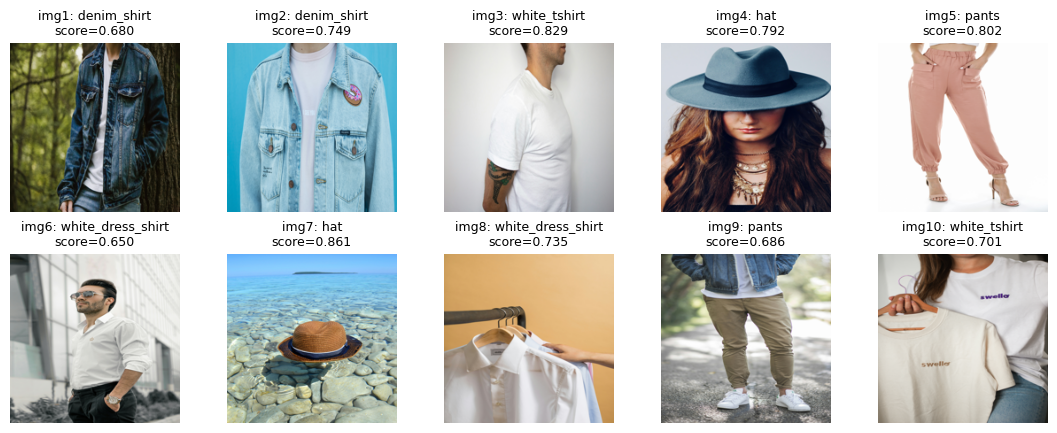

[saved] /workspace/out/thumbs_pred_top1_prompt_ensemble.png


In [34]:
probs, cat_names = score_images(
        image_paths=imgs,
        prototypes=prototypes,
        embedder=embedder,
        beta=0.2, temperature=0.7, zscore_per_image=True
    )
plot_top1_grid(imgs, probs, cat_names, out_dir="out", cols=5, thumb_size=192)

In [35]:
def plot_clip_heatmap_ic(S_ic, cat_names, imgs, out_path):
    """
    S_ic : (N_images, K_categories) numpy array or torch.Tensor (cosine-similarity or scores)
    cat_names : list[str] length K
    imgs : list of image paths (or any list; only length is used for y-ticks)
    out_path : str or Path, e.g., OUT / "clip_heatmap_ic_annot.png"
    """
    # to numpy
    if hasattr(S_ic, "detach"):
        S_ic = S_ic.detach().cpu().numpy()
    else:
        S_ic = np.asarray(S_ic)

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    # figure size heuristics
    W = max(6, 0.9 * len(cat_names))
    H = max(4, 0.5 * len(imgs))
    fig = plt.figure(figsize=(W, H))
    ax = plt.gca()

    im = ax.imshow(S_ic, aspect="auto")
    ax.set_title("CLIP cosine-similarity: images × categories")
    ax.set_xlabel("Category")
    ax.set_ylabel("Image")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("similarity", rotation=90)

    ax.set_xticks(range(len(cat_names)))
    ax.set_xticklabels(cat_names, rotation=45, ha="right")
    ax.set_yticks(range(len(imgs)))
    ax.set_yticklabels([f"img{i+1}" for i in range(len(imgs))])

    # annotate values if small matrix
    if S_ic.size <= 200:
        for i in range(S_ic.shape[0]):
            for j in range(S_ic.shape[1]):
                ax.text(j, i, f"{S_ic[i, j]:.2f}", ha="center", va="center", fontsize=7)

    plt.tight_layout()
    fig.savefig(out_path, dpi=160)
    plt.show()
    plt.close(fig)
    return out_path

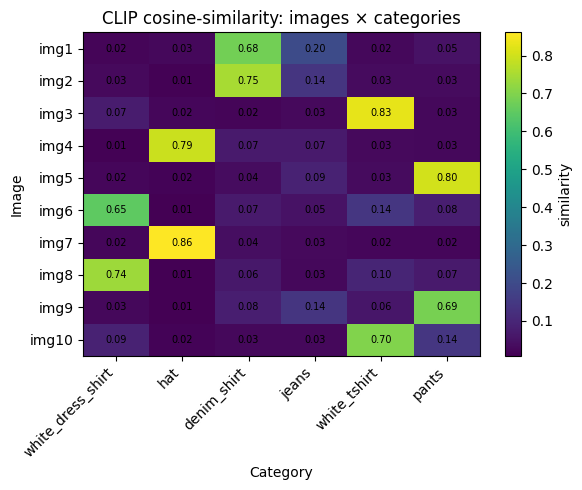

PosixPath('/workspace/out/clip_heatmap_ic_annot.png')

In [36]:
S_ic = probs.numpy()
plot_clip_heatmap_ic(S_ic, cat_names, imgs, OUT / "clip_heatmap_ic_annot.png")